# Seminarska naloga

## Pridobivanje podatkovne baze

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("teejmahal20/airline-passenger-satisfaction")

print("Path to dataset files:", path)

c:\Users\porek\anaconda3\envs\VUVI\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.71M/2.71M [00:00<00:00, 3.56MB/s]

Extracting files...


Path to dataset files: C:\Users\porek\.cache\kagglehub\datasets\teejmahal20\airline-passenger-satisfaction\versions\1


## Opis spremenljivk

Gender: Gender of the passengers (Female, Male)

Customer Type: The customer type (Loyal customer, disloyal customer)

Age: The actual age of the passengers

Type of Travel: Purpose of the flight of the passengers (Personal Travel, Business Travel)

Class: Travel class in the plane of the passengers (Business, Eco, Eco Plus)

Flight distance: The flight distance of this journey

Inflight wifi service: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)

Departure/Arrival time convenient: Satisfaction level of Departure/Arrival time convenient

Ease of Online booking: Satisfaction level of online booking

Gate location: Satisfaction level of Gate location

Food and drink: Satisfaction level of Food and drink

Online boarding: Satisfaction level of online boarding

Seat comfort: Satisfaction level of Seat comfort

Inflight entertainment: Satisfaction level of inflight entertainment

On-board service: Satisfaction level of On-board service

Leg room service: Satisfaction level of Leg room service

Baggage handling: Satisfaction level of baggage handling

Check-in service: Satisfaction level of Check-in service

Inflight service: Satisfaction level of inflight service

Cleanliness: Satisfaction level of Cleanliness

Departure Delay in Minutes: Minutes delayed when departure

Arrival Delay in Minutes: Minutes delayed when Arrival

Satisfaction: Airline satisfaction level(Satisfaction, neutral or dissatisfaction)

## Pregled podatkov

Podatkov samih nisma spreminjala, čistila, saj so že bili počiščeni z namenom klasifikacije. Tako je navedel avtor podatkovne zbirke.

Citat avtorja:

"Note that this data set was modified from this dataset by John D here. It has been cleaned up for the purposes of classification."

## Deskriptivna statistika z grafi

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

In [6]:
df = pd.read_csv('teejmahal20/airline-passenger-satisfaction/versions/1/train.csv')
print(f"\nVelikost podatkovne baze: {df.shape}")
print(f"Število vrstic: {df.shape[0]}")
print(f"Število stolpcev: {df.shape[1]}")


Velikost podatkovne baze: (103904, 25)
Število vrstic: 103904
Število stolpcev: 25


In [7]:
# Identificiraj numerične spremenljivke
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Izračunaj statistike
desc_stats = pd.DataFrame()
for col in numeric_cols:
    data = df[col].dropna()
    desc_stats[col] = {
        'N': len(data),
        'Mean': data.mean(),
        'SD': data.std(),
        'Median': data.median(),
        'Q1': data.quantile(0.25),
        'Q3': data.quantile(0.75),
        'Min': data.min(),
        'Max': data.max(),
        'Skewness': stats.skew(data),
        'Kurtosis': stats.kurtosis(data)
    }

desc_stats = desc_stats.T
desc_stats = desc_stats.round(2)
print(desc_stats.to_string())

                                          N      Mean        SD   Median        Q1        Q3   Min       Max  Skewness  Kurtosis
Unnamed: 0                         103904.0  51951.50  29994.65  51951.5  25975.75  77927.25   0.0  103903.0      0.00     -1.20
id                                 103904.0  64924.21  37463.81  64856.5  32533.75  97368.25   1.0  129880.0      0.00     -1.20
Age                                103904.0     39.38     15.11     40.0     27.00     51.00   7.0      85.0     -0.00     -0.72
Flight Distance                    103904.0   1189.45    997.15    843.0    414.00   1743.00  31.0    4983.0      1.11      0.27
Inflight wifi service              103904.0      2.73      1.33      3.0      2.00      4.00   0.0       5.0      0.04     -0.85
Departure/Arrival time convenient  103904.0      3.06      1.53      3.0      2.00      4.00   0.0       5.0     -0.33     -1.04
Ease of Online booking             103904.0      2.76      1.40      3.0      2.00      4.00   0.

In [8]:
# Identificiraj kategorične spremenljivke
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

cat_stats = pd.DataFrame()
for col in categorical_cols:
    value_counts = df[col].value_counts()
    percentages = df[col].value_counts(normalize=True) * 100
    
    print(f"\n{col}:")
    print("-" * 40)
    for val in value_counts.index:
        n = value_counts[val]
        pct = percentages[val]
        print(f"  {val}: {n} ({pct:.1f}%)")


Gender:
----------------------------------------
  Female: 52727 (50.7%)
  Male: 51177 (49.3%)

Customer Type:
----------------------------------------
  Loyal Customer: 84923 (81.7%)
  disloyal Customer: 18981 (18.3%)

Type of Travel:
----------------------------------------
  Business travel: 71655 (69.0%)
  Personal Travel: 32249 (31.0%)

Class:
----------------------------------------
  Business: 49665 (47.8%)
  Eco: 46745 (45.0%)
  Eco Plus: 7494 (7.2%)

satisfaction:
----------------------------------------
  neutral or dissatisfied: 58879 (56.7%)
  satisfied: 45025 (43.3%)


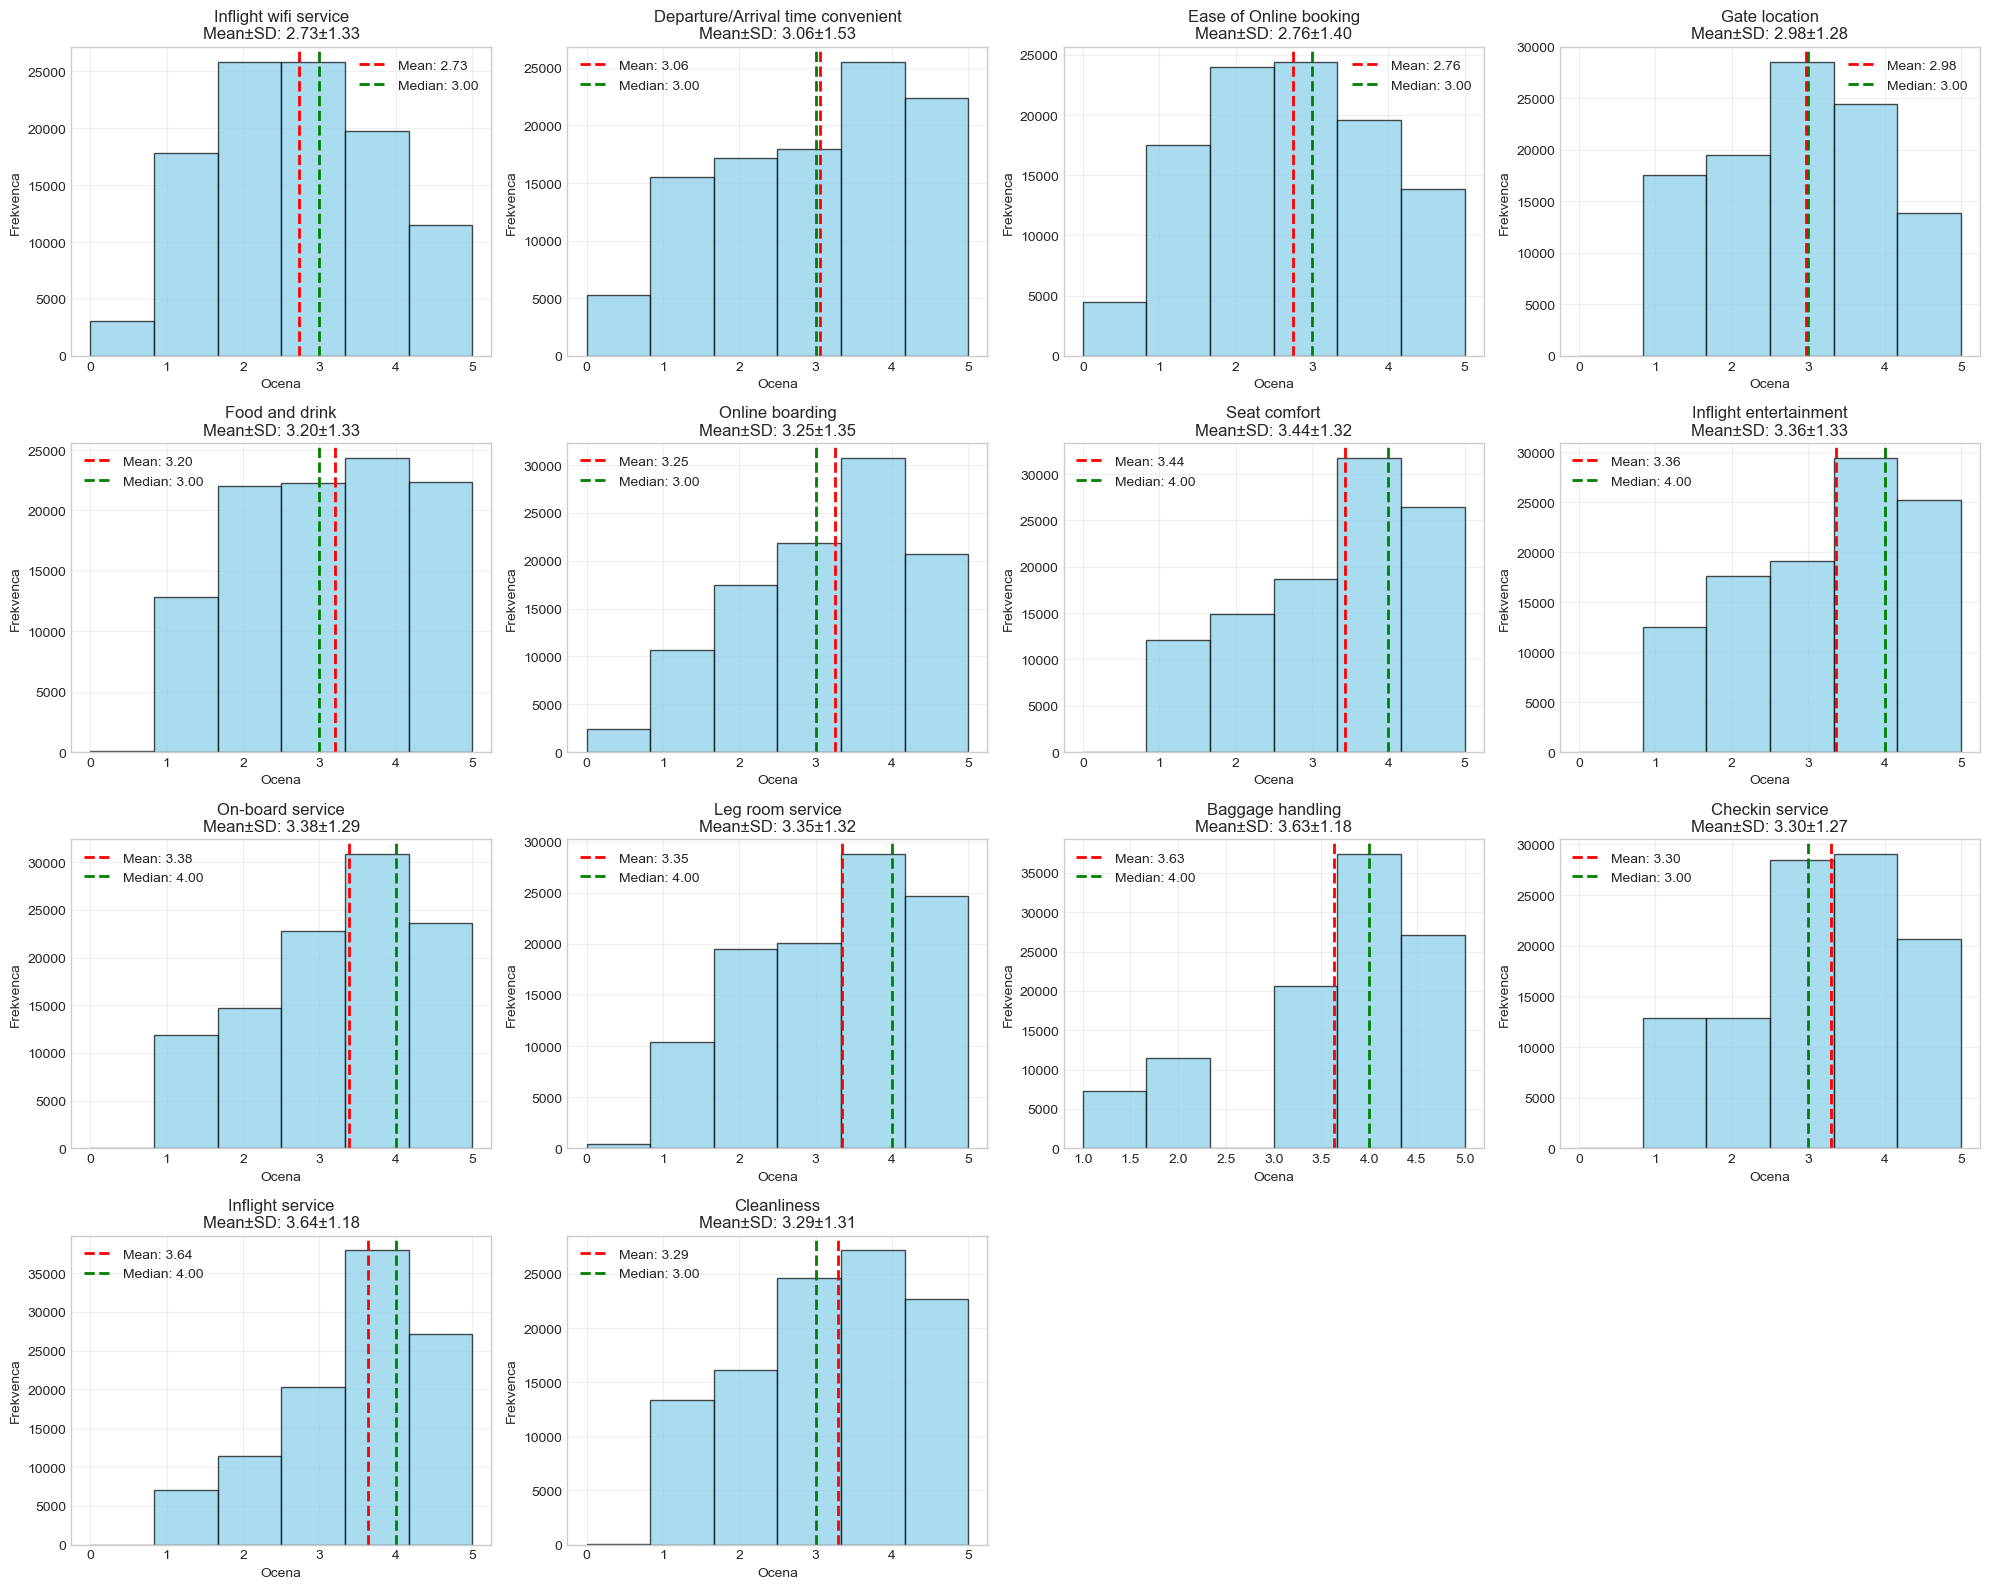

In [14]:
# 1. NUMERIČNE SPREMENLJIVKE - Histogrami

# Rating spremenljivke (0-5)
rating_cols = [col for col in numeric_cols if df[col].max() <= 5 and col not in 
               ['Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes', 'Flight_Distance', 'Age']]

if rating_cols:
    n_cols = 4
    n_rows = int(np.ceil(len(rating_cols) / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
    axes = axes.flatten() if n_rows > 1 else [axes]
    
    for idx, col in enumerate(rating_cols):
        ax = axes[idx]
        data = df[col].dropna()
        
        # Histogram
        ax.hist(data, bins=6, edgecolor='black', alpha=0.7, color='skyblue')
        ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}')
        ax.axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {data.median():.2f}')
        
        ax.set_xlabel('Ocena')
        ax.set_ylabel('Frekvenca')
        ax.set_title(f'{col}\nMean±SD: {data.mean():.2f}±{data.std():.2f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Skrij prazne subplote
    for idx in range(len(rating_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

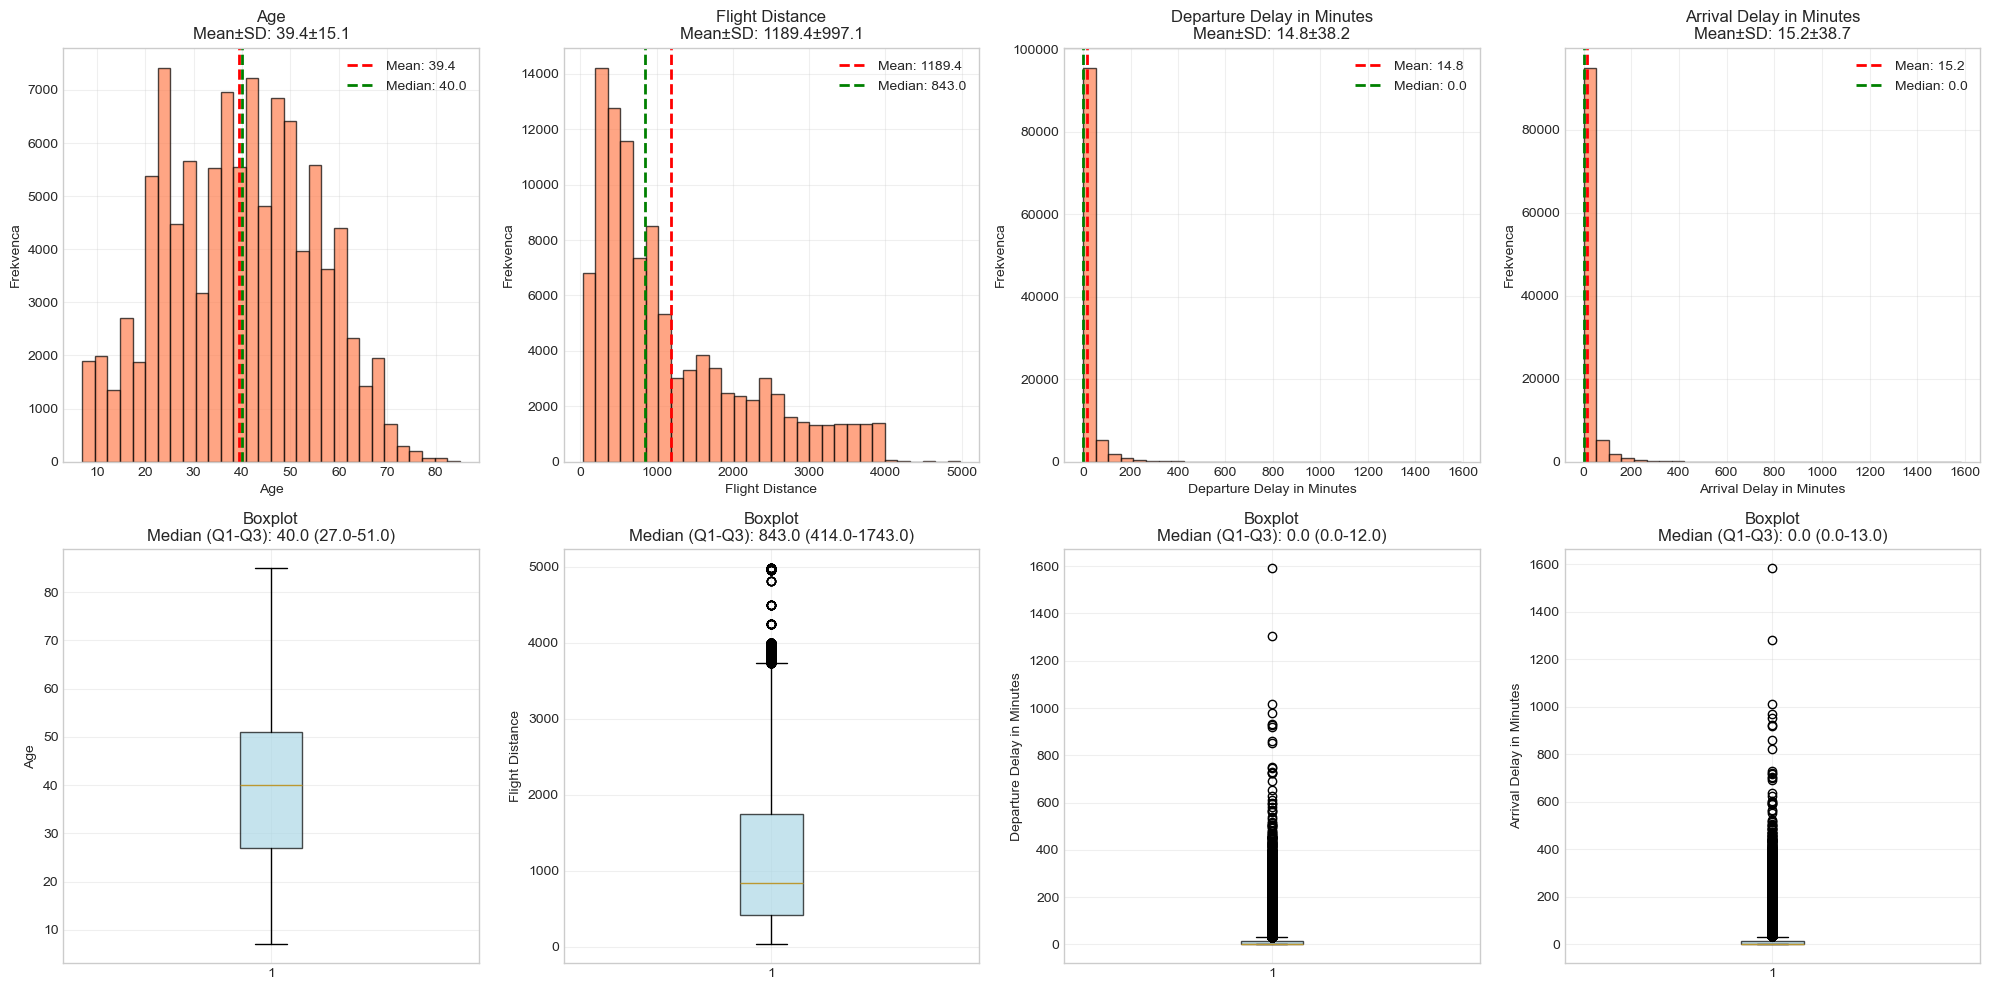

In [13]:
# 2. Kontinuirane spremenljivke - Histogrami + Boxploti
continuous_vars = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, col in enumerate(continuous_vars):
    data = df[col].dropna()
    
    # Histogram
    ax1 = axes[0, idx]
    ax1.hist(data, bins=30, edgecolor='black', alpha=0.7, color='coral')
    ax1.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.1f}')
    ax1.axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {data.median():.1f}')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Frekvenca')
    ax1.set_title(f'{col}\nMean±SD: {data.mean():.1f}±{data.std():.1f}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Boxplot
    ax2 = axes[1, idx]
    bp = ax2.boxplot(data, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_alpha(0.7)
    ax2.set_ylabel(col)
    ax2.set_title(f'Boxplot\nMedian (Q1-Q3): {data.median():.1f} ({data.quantile(0.25):.1f}-{data.quantile(0.75):.1f})')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

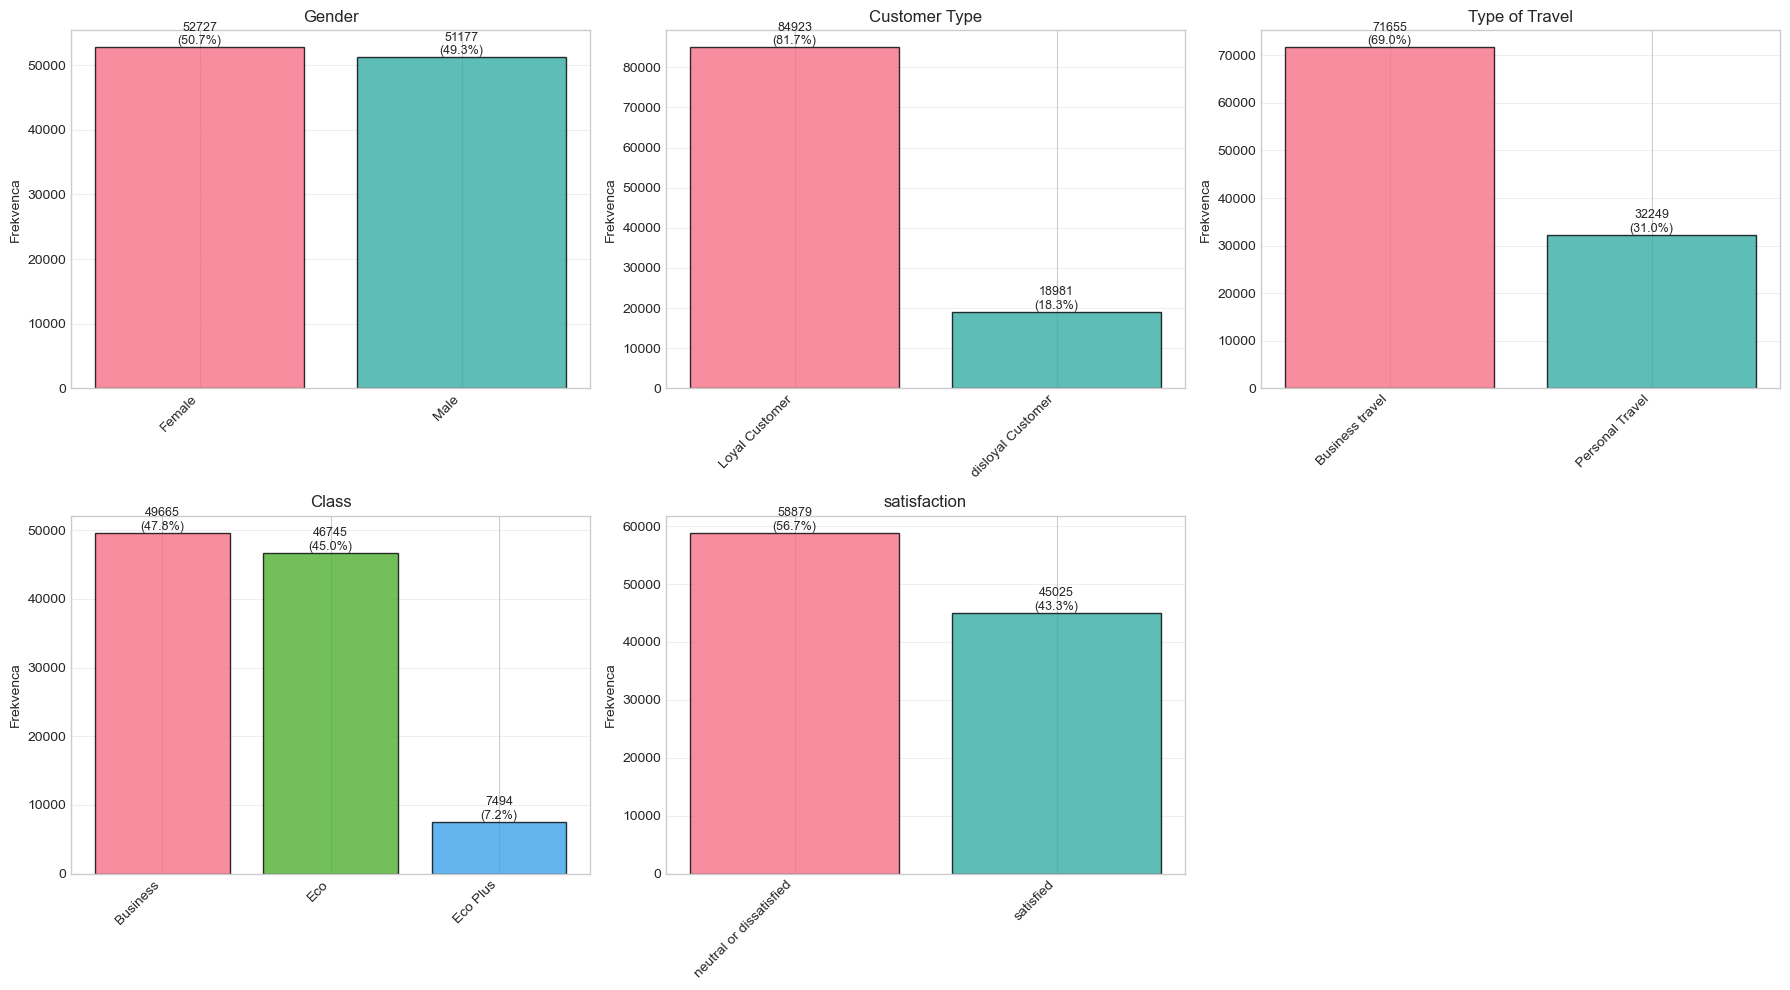

In [12]:
# 3. KATEGORIČNE SPREMENLJIVKE - Barploti
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    ax = axes[idx]
    
    value_counts = df[col].value_counts()
    percentages = (value_counts / len(df) * 100).round(1)
    
    bars = ax.bar(range(len(value_counts)), value_counts.values, 
                   color=sns.color_palette("husl", len(value_counts)),
                   edgecolor='black', alpha=0.8)
    
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
    ax.set_ylabel('Frekvenca')
    ax.set_title(f'{col}')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Dodaj odstotke na stolpce
    for i, (bar, pct) in enumerate(zip(bars, percentages)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({pct}%)',
                ha='center', va='bottom', fontsize=9)

# Skrij prazne subplote
for idx in range(len(categorical_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

### Interpretacija

#### NUMERIČNE SPREMENLJIVKE

1. DEMOGRAFSKE KARAKTERISTIKE

Starost (Age)

    Povprečje: 39.38 ± 15.11 let

    Razpon: 7-85 let
    Opažanja:

    Širok spekter potnikov od otrok do starejših

    Skewness blizu 0 (-0.00) → skoraj popolnoma simetrična porazdelitev

    Negativna kurtosis (-0.72) → bolj ploščata porazdelitev od normalne

    Mediana (40) ≈ mean → potrjuje simetričnost

    Zaključek: Reprezentativen vzorec različnih starostnih skupin, brez izrazitih odstopanj


2. KARAKTERISTIKE LETA

Flight Distance

    Povprečje: 1189.45 ± 997.15 km

    Mediana: 843 km (nižja od povprečja!)

    Razpon: 31-4983 km

    Opažanja:

    Pozitivna skewness (1.11) → desno asimetrična porazdelitev

    Večina letov je krajših (Q3 = 1743 km), nekaj zelo dolgih letov dvigne povprečje

    Zaključek: Prevladujejo kratki do srednje dolgi leti, z manjšim deležem intercontinentalnih letov



Zamude

    Departure Delay: 14.82 ± 38.23 min (mediana = 0!)

    Arrival Delay: 15.18 ± 38.70 min (mediana = 0!)

    Opažanja:

    EKSTREMNO visoka skewness (6.73 in 6.60) → močno desno asimetrična

    EKSTREMNO visoka kurtosis (100.26 in 94.53) → prisotnost ekstremnih vrednosti

    Max zamude: 1592 min (26.5 ur!) in 1584 min

    50% letov odide in prispe brez zamude (mediana = 0)

    Q3 = 12-13 min → 75% letov ima zamudo < 15 min

    Zaključek: Večina letov je punktualnih, redke ekstremne zamude močno vplivajo na povprečje in variabilnost



3. OCENE STORITEV (0-5 lestvica)

Razdelitev po povprečnih ocenah:

    NAJVIŠJE OCENJENE STORITVE (≥ 3.6):

        Inflight service: 3.64 ± 1.18 (najboljša!)

        Baggage handling: 3.63 ± 1.18

        Seat comfort: 3.44 ± 1.32

        SREDNJE OCENJENE (3.2-3.4):

        On-board service: 3.38 ± 1.29

        Inflight entertainment: 3.36 ± 1.33

        Leg room service: 3.35 ± 1.32

        Checkin service: 3.30 ± 1.27

        Cleanliness: 3.29 ± 1.31

        Online boarding: 3.25 ± 1.35

        Food and drink: 3.20 ± 1.33

    NAJNIŽJE OCENJENE (< 3.1):

        Departure/Arrival time convenient: 3.06 ± 1.53

        Gate location: 2.98 ± 1.28

        Ease of Online booking: 2.76 ± 1.40

        Inflight wifi service: 2.73 ± 1.33 (najslabša!)

Ključna opažanja pri ocenah:

    Negativna skewness pri večini storitev → več višjih kot nižjih ocen

    Negativna kurtosis → ocene so dokaj enakomerno razporejene po lestvici

    Največja variabilnost (SD > 1.4): Departure/Arrival time convenient, Ease of Online booking

    Najmanjša variabilnost (SD < 1.2): Baggage handling, Inflight service

    Nobena storitev NI ocenjena odlično (vse < 3.7)

    WiFi je največja šibka točka letalske družbe

#### KATEGORIČNE SPREMENLJIVKE

1. DEMOGRAFSKA STRUKTURA

Gender

    Skoraj popolnoma uravnoteženo: 50.7% ženske, 49.3% moški

    Odličen vzorec za analizo brez gender bias

    Customer Type

    81.7% Loyal Customers vs 18.3% disloyal

    Pomembno: Velika večina so zvesti/redni potniki

    To lahko vpliva na pričakovanja in ocene storitev

    Lojalnost ne pomeni nujno zadovoljstva!

2. TIP POTOVANJA

Type of Travel

    69.0% Business travel vs 31.0% Personal

    Ključno spoznanje: Poslovni potniki so primarna ciljna skupina

    Različna pričakovanja: business potniki bolj zahtevni glede WiFi, časa, udobja

Class

    Business: 47.8%

    Economy: 45.0%

    Economy Plus: 7.2%

    Skoraj enakomerna porazdelitev med Business in Eco

    Eco Plus je niša produkt

3. CILJNA SPREMENLJIVKA - ZADOVOLJSTVO

Satisfaction

    56.7% nezadovoljnih (neutral or dissatisfied)

    43.3% zadovoljnih

    KRITIČNO: Več kot polovica potnikov ni zadovoljna!

    To predstavlja velik prostor za izboljšave

## Bivariantna analiza